In [3]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from tqdm import tqdm

In [4]:
def get_tree_rep(model, X):
    n_leaves = X.shape[0]
    tree_rep = [{'node_id': n_leaves + i, 'left': x[0], 'right':x[1], 'dist': model.distances_[i]} for i, x in enumerate(model.children_)]
    return tree_rep

In [5]:
def get_leaves(node_id, tree_rep, X):
    n_leaves = tree_rep[0]['node_id']
    if node_id < n_leaves:
        return [node_id]
    else:
        tree_rep_index = node_id - n_leaves
        left_id = tree_rep[tree_rep_index]['left']
        right_id = tree_rep[tree_rep_index]['right']
        left_leaves = get_leaves(left_id, tree_rep, X)
        right_leaves = get_leaves(right_id, tree_rep, X)
        return left_leaves + right_leaves

def get_random_perm(matrix):
    num_cols = matrix.shape[1]
    # Generate a random permutation for each column
    permutations = [np.random.permutation(matrix[:, i]) for i in range(num_cols)]
    # Apply each permutation to the corresponding column of the matrix
    permuted_matrix = np.column_stack(permutations)
    return permuted_matrix

def find_stops2(split_indic, i, tree_rep):
    n_leaves = tree_rep[0]['node_id']
    tree_rep_index = i - n_leaves
    if i < n_leaves:
        return [i]
    else:
        if split_indic[tree_rep_index] == False:
            return [i]
        else:
            left_id = tree_rep[tree_rep_index]['left']
            right_id = tree_rep[tree_rep_index]['right']
            return find_stops2(split_indic, left_id, tree_rep) + find_stops2(split_indic, right_id, tree_rep)
def get_labels2(split_indic, tree_rep):
    #Xnorm = ((X.T - X.mean(axis=1)) / X.std(axis=1)).T
    max_id = tree_rep[-1]['node_id']
    stops = find_stops2(split_indic, max_id, tree_rep)
    n_leaves = tree_rep[0]['node_id']
    labels = np.zeros(n_leaves, dtype=np.int32)
    for i, stop_id in enumerate(stops):
        stop_leaf_idx = get_leaves(stop_id, tree_rep, X)
        labels[stop_leaf_idx] = i
    return labels, len(stops)

def sig_agglo(Z, alpha = 0.01, n_trees = 100):
    # Step 1
    nv = Z.shape[1]
    # Step 2
    model = AgglomerativeClustering(compute_distances=True, linkage='complete').fit(Z)
    D_o = model.distances_ #/ np.sqrt(nv) 
    D_o = np.sort(D_o)
    # Step 3:
    R = n_trees
    Dis = np.zeros((R, len(D_o)))
    for r in tqdm(range(R)):
        # Step 3.1
        Zi = get_random_perm(Z)
        model_i = AgglomerativeClustering(compute_distances=True, linkage='complete').fit(Zi)
        Dis[r] = model_i.distances_
    # Step 4
    De = Dis.sum(axis=0) / r #/ np.sqrt(nv)
    De = np.sort(De)
    # Step 6
    ref_extr = De[int(len(De) * (1-alpha))]
    split_indic = D_o > ref_extr
    tree_rep = get_tree_rep(model, Z)
    labels, n_labels = get_labels2(split_indic, tree_rep)
    return labels

In [6]:
n_samples = 500
X,y = datasets.make_blobs(n_samples=n_samples, random_state=8)

In [7]:
labels = sig_agglo(X)

100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 128.68it/s]


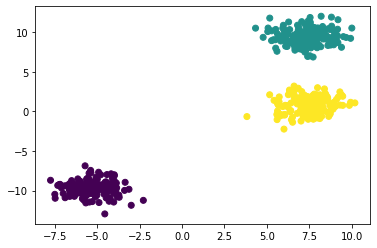

In [8]:
plt.scatter(X[:,0], X[:,1], c=labels)

# CNV

In [9]:
import scanpy as sc
import infercnvpy as cnv

In [10]:
adata = cnv.datasets.maynard2020_3k()

In [12]:
cnv.tl.infercnv(
    adata,
    reference_key="cell_type",
    reference_cat=[
        "B cell",
        "Macrophage",
        "Mast cell",
        "Monocyte",
        "NK cell",
        "Plasma cell",
        "T cell CD4",
        "T cell CD8",
        "T cell regulatory",
        "mDC",
        "pDC",
    ],
    window_size=250,
    n_jobs=4
)

  0%|          | 0/1 [00:01<?, ?it/s]

In [13]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

/Users/kasperrasmussen/miniconda3/envs/nneng_0.0.0/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11102. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [14]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

In [16]:
labels_agglo = sig_agglo(adata.obsm['X_cnv_pca'], alpha=0.01, n_trees=300)

100%|████████████████████████████████████████████████████████████████████████████| 300/300 [02:58<00:00,  1.68it/s]


In [17]:
adata.obs['cnv_agglo'] = [str(item) for item in labels_agglo]

... storing 'cnv_agglo' as categorical


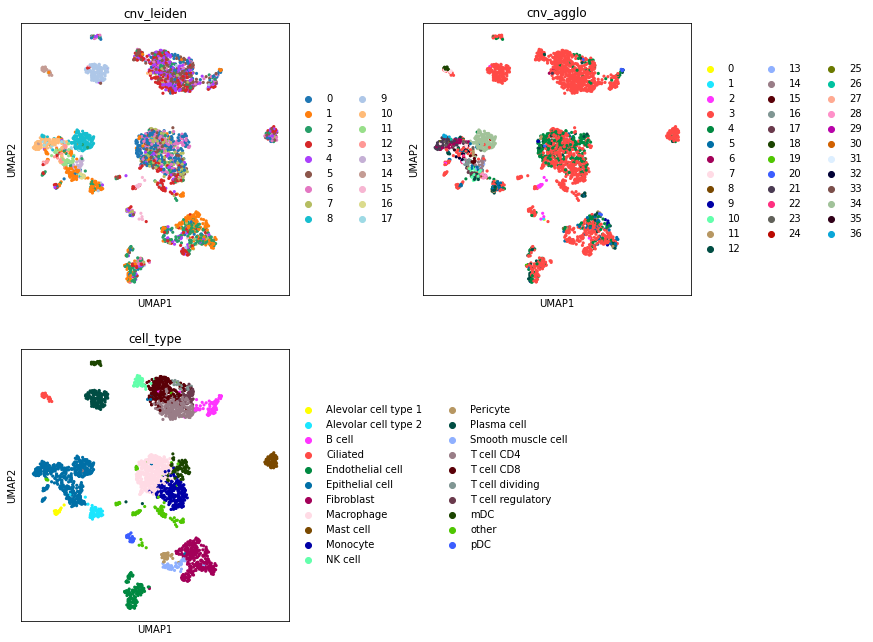

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(12, 11), gridspec_kw=dict(wspace=0.5)
)
ax4.axis("off")
sc.pl.umap(adata, color="cnv_leiden", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_agglo", ax=ax2, show=False)
sc.pl.umap(adata, color="cell_type", ax=ax3)

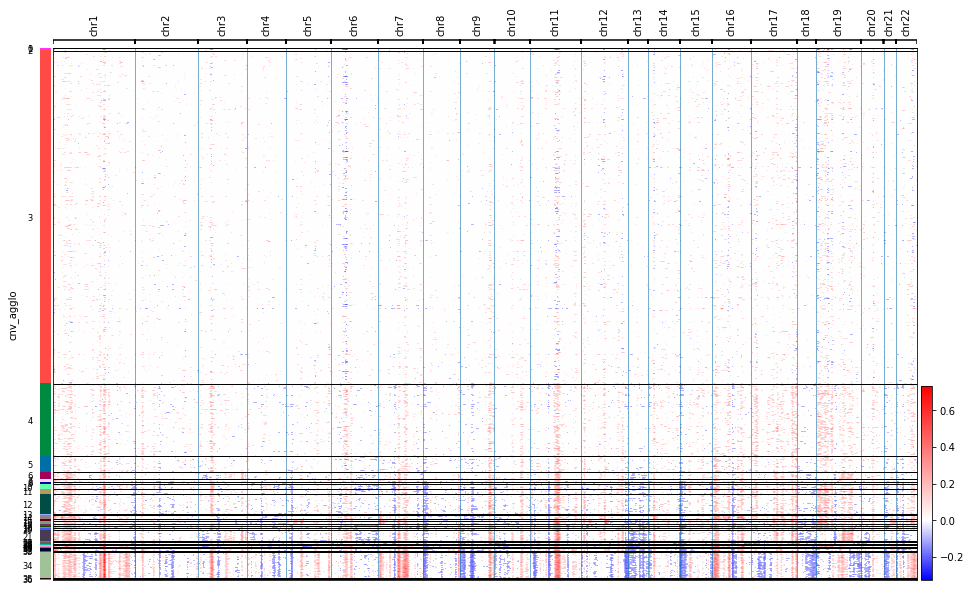

In [19]:
cnv.pl.chromosome_heatmap(adata, use_rep='cnv', groupby="cnv_agglo")

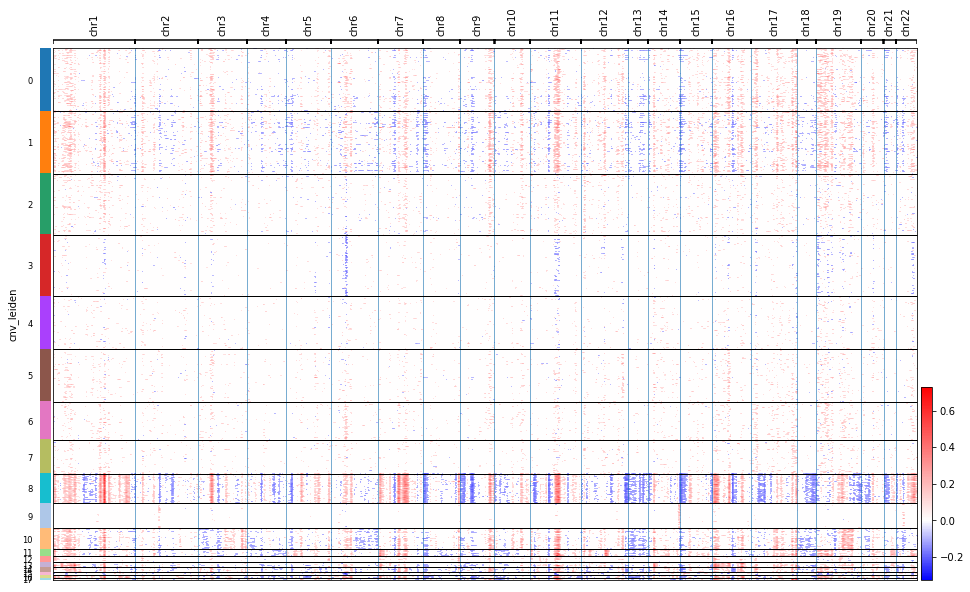

In [20]:
cnv.pl.chromosome_heatmap(adata, use_rep='cnv', groupby="cnv_leiden")